In [1]:
import PID
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
%matplotlib inline

## define PID weights

PID controller minimizes error by adjusting a control variable (eg power supplied) to a new value determined by a weighted sum of present (P), past (I), and future (D) error values.

In [2]:
P = 1.5 # weight current errors more
I = 3
D = 0.0 # ignore future potential errors 

In [3]:
L = 50 # number of iterations

In [4]:
pid = PID.PID(P, I, D)

pid.SetPoint=0.0
pid.setSampleTime(0.01)

END = L
feedback = 0

feedback_list = []
time_list = []
setpoint_list = []

p_term_list = []
i_term_list = []
d_term_list = []

for i in range(1, END):
    pid.update(feedback)
    
    p_term_list.append(pid.PTerm)
    i_term_list.append(pid.ITerm)
    d_term_list.append(pid.DTerm)
    
    output = pid.output
    if pid.SetPoint > 0:
        feedback += (output - (1/i))
    if i>9:
        pid.SetPoint = 1
    time.sleep(0.02)

    feedback_list.append(feedback)
    setpoint_list.append(pid.SetPoint)
    time_list.append(i)

time_sm = np.array(time_list)
time_smooth = np.linspace(time_sm.min(), time_sm.max(), 300) 
feedback_smooth = make_interp_spline(time_list, feedback_list)(time_smooth)

## how quickly does it converge?

green is desired value; blue is actual

(0.5, 1.5)

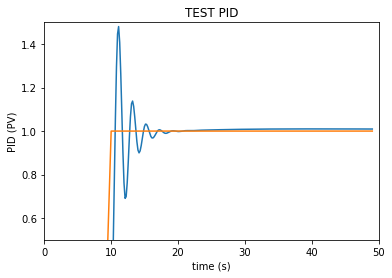

In [5]:
plt.plot(time_smooth, feedback_smooth)
plt.plot(time_list, setpoint_list)
plt.xlim((0, L))
plt.ylim((min(feedback_list)-0.5, max(feedback_list)+0.5))
plt.xlabel('time (s)')
plt.ylabel('PID (PV)')
plt.title('TEST PID')

plt.ylim((1-0.5, 1+0.5))

## 가설 1 : PTerm, ITerm, DTerm의 변화가 크지 않다?

각 Term의 차이가 크지 않다면(차이가 거의 없다면), 한번 trial한 데이터로 최적의 P, I, D값을 뽑을 수 있지 않을까?

In [6]:
cases = [(1.5,5,0),(1.3,3,0.001),(1.2,2,0.0001)]

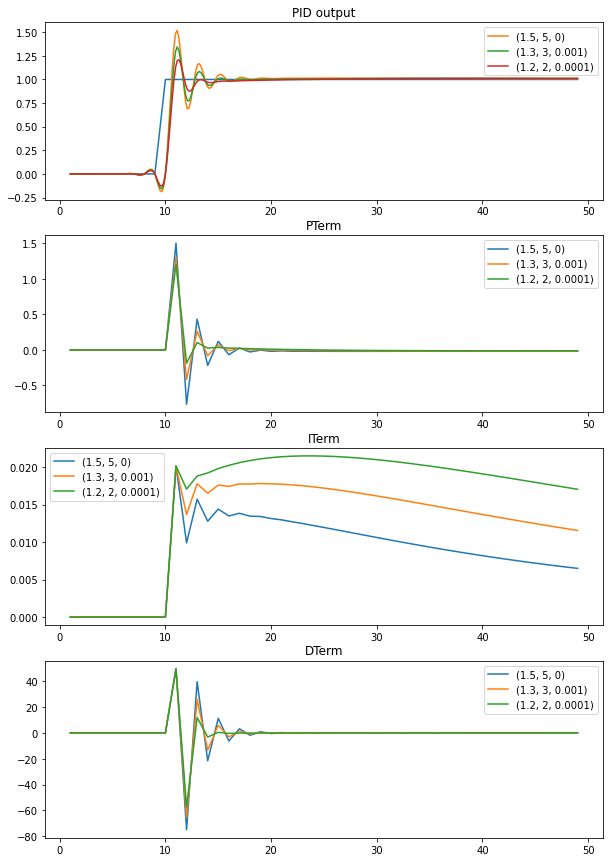

In [7]:
plt.figure(figsize=(10,15))
plt.xlabel('time (s)')

ax_pid = plt.subplot(4,1,1)
ax_p = plt.subplot(4,1,2)
ax_i = plt.subplot(4,1,3)
ax_d = plt.subplot(4,1,4)

ax_pid.set_title('PID output')
ax_p.set_title('PTerm')
ax_i.set_title('ITerm')
ax_d.set_title('DTerm')

# SetPoint Plot Setting
ax_pid.plot(time_list, setpoint_list)


for case in cases:
    pid = PID.PID(*case)

    pid.SetPoint=0.0
    pid.setSampleTime(0.01)

    END = L
    feedback = 0

    feedback_list = []
    time_list = []
    setpoint_list = []

    p_term_list = []
    i_term_list = []
    d_term_list = []

    for i in range(1, END):
        pid.update(feedback)

        p_term_list.append(pid.PTerm)
        i_term_list.append(pid.ITerm)
        d_term_list.append(pid.DTerm)

        output = pid.output
        if pid.SetPoint > 0:
            feedback += (output - (1/i))
        if i>9:
            pid.SetPoint = 1
        time.sleep(0.02)

        feedback_list.append(feedback)
        setpoint_list.append(pid.SetPoint)
        time_list.append(i)

    time_sm = np.array(time_list)
    time_smooth = np.linspace(time_sm.min(), time_sm.max(), 300) 
    feedback_smooth = make_interp_spline(time_list, feedback_list)(time_smooth)
    
    ax_pid.plot(time_smooth, feedback_smooth, label=f'{case}')
    ax_pid.legend()
    
    ax_p.plot(time_list, p_term_list, label=f'{case}')
    ax_p.legend()
    
    ax_i.plot(time_list, i_term_list, label=f'{case}')
    ax_i.legend()
    
    ax_d.plot(time_list, d_term_list, label=f'{case}')
    ax_d.legend()
    
    
plt.show()

차이가 많이 난다.

## 가설2 : 첫번째 시도의 데이터를 통해 PID를 바꾼다면 output은 어떻게 바뀔까?

In [88]:
episodes = 5
L = 50
lr_p = 0.01
lr_i = 0.01
lr_d = 0.00000001

In [89]:
pid = PID.PID(1.5,1.5,0)

pid.SetPoint=0.0
pid.setSampleTime(0.01)

END = L
feedback = 0

feedback_list = []
time_list = []
setpoint_list = []

p_term_list = []
i_term_list = []
d_term_list = []
error_list = []

for i in range(1, END):
    pid.update(feedback)
    
    p_term_list.append(pid.PTerm)
    i_term_list.append(pid.ITerm)
    d_term_list.append(pid.DTerm)
    error_list.append(pid.last_error)
    
    output = pid.output
    if pid.SetPoint > 0:
        feedback += (output - (1/i))
    if i>9:
        pid.SetPoint = 1
    time.sleep(0.02)

    feedback_list.append(feedback)
    setpoint_list.append(pid.SetPoint)
    time_list.append(i)

time_sm = np.array(time_list)
time_smooth = np.linspace(time_sm.min(), time_sm.max(), 300) 
feedback_smooth = make_interp_spline(time_list, feedback_list)(time_smooth)

(0.5, 1.5)

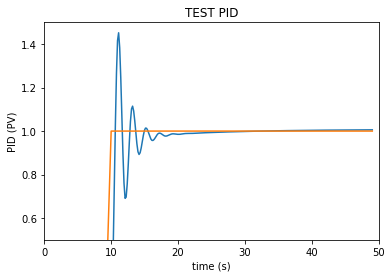

In [90]:
plt.plot(time_smooth, feedback_smooth)
plt.plot(time_list, setpoint_list)
plt.xlim((0, L))
plt.ylim((min(feedback_list)-0.5, max(feedback_list)+0.5))
plt.xlabel('time (s)')
plt.ylabel('PID (PV)')
plt.title('TEST PID')

plt.ylim((1-0.5, 1+0.5))

In [91]:
## PTerm, ITerm, DTerm을 state로 쓰기위해 time별로 묶기

states = np.array([p_term_list, i_term_list, d_term_list])
states_t = np.transpose(states)

In [92]:
states_t[8:15]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.50000000e+00,  2.02105045e-02,  4.94792200e+01],
       [-6.59109999e-01,  1.13616172e-02, -7.14762051e+01],
       [ 4.28991361e-01,  1.71231584e-02,  3.60078100e+01],
       [-1.37638171e-01,  1.52734145e-02, -1.87388945e+01],
       [ 1.41596760e-01,  1.71755034e-02,  9.23867597e+00]])

In [93]:
## reward 전처리
rewards = np.abs(np.array(error_list))*(-1)
rewards[6:15]

array([-0.        , -0.        , -0.        , -0.        , -1.        ,
       -0.43940667, -0.28599424, -0.09175878, -0.09439784])

In [94]:
## Policy output 조정
policy_outputs = np.array(feedback_list)

In [95]:
print(len(states_t))
print(len(policy_outputs))
print(len(rewards))

49
49
49


In [96]:
# REINFORCE

## Initialization
T = L
kp = 1.5
ki = 5
kd = 0
learning_rate = 0.000001

In [97]:
action = [kp, ki, kd]
states = states_t
policy_outputs = policy_outputs
rewards = rewards

for _ in range(episodes):
    for i in range(0,T-1):
        g = np.sum(rewards[i:])
        kp += lr_p * (states[i][0]/policy_outputs[i])*g if policy_outputs[i] != 0 else 0
        ki += lr_i * (states[i][1]/policy_outputs[i])*g if policy_outputs[i] != 0 else 0
        kd += lr_d * (states[i][2]/policy_outputs[i])*g if policy_outputs[i] != 0 else 0

    print(kp, ki, kd)

1.4853257180051973 4.998782299517812 2.3990458794813135e-07
1.4706514360103946 4.9975645990356234 4.798091758962629e-07
1.455977154015592 4.996346898553435 7.197137638443945e-07
1.4413028720207892 4.995129198071247 9.59618351792526e-07
1.4266285900259865 4.993911497589059 1.1995229397406573e-06


In [98]:
# kp = 1.5
# ki = 5
# kd = 0

1.4266285900259865 4.993911497589059 1.1995229397406573e-06


(0.5, 1.5)

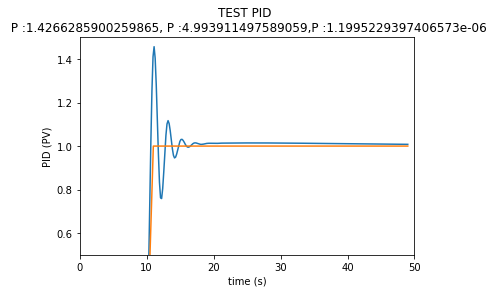

In [99]:
## 결과 확인하기
print(kp, ki, kd)
pid = PID.PID(kp, ki, kd)

pid.SetPoint=0.0
pid.setSampleTime(0.01)

END = L
feedback = 0

feedback_list = []
time_list = []
setpoint_list = []

for i in range(1, END):
    pid.update(feedback)    
    output = pid.output
    if pid.SetPoint > 0:
        feedback += (output - (1/i))
    if i>9:
        pid.SetPoint = 1
    time.sleep(0.02)

    feedback_list.append(feedback)
    setpoint_list.append(pid.SetPoint)
    time_list.append(i)

time_sm = np.array(time_list)
time_smooth = np.linspace(time_sm.min(), time_sm.max(), 300) 
feedback_smooth = make_interp_spline(time_list, feedback_list)(time_smooth)

plt.plot(time_smooth, feedback_smooth)
plt.plot(time_list[1:], setpoint_list[:-1])
plt.xlim((0, L))
plt.ylim((min(feedback_list)-0.5, max(feedback_list)+0.5))
plt.xlabel('time (s)')
plt.ylabel('PID (PV)')
plt.title(f'TEST PID \n P :{kp}, P :{ki},P :{kd}')

plt.ylim((1-0.5, 1+0.5))

결과가 나아졌는데 만약 이 과정을 한번 더 거치면 어떻게 되는지 궁금해졌다.

In [100]:
# 재시도

L = 50
print(kp, ki, kd)
pid = PID.PID(kp, ki, kd)

pid.SetPoint=0.0
pid.setSampleTime(0.01)

END = L
feedback = 0

feedback_list = []
time_list = []
setpoint_list = []

p_term_list = []
i_term_list = []
d_term_list = []
error_list = []

for i in range(1, END):
    pid.update(feedback)
    
    p_term_list.append(pid.PTerm)
    i_term_list.append(pid.ITerm)
    d_term_list.append(pid.DTerm)
    error_list.append(pid.last_error)
    
    output = pid.output
    if pid.SetPoint > 0:
        feedback += (output - (1/i))
    if i>9:
        pid.SetPoint = 1
    time.sleep(0.02)

    feedback_list.append(feedback)
    setpoint_list.append(pid.SetPoint)
    time_list.append(i)

time_sm = np.array(time_list)
time_smooth = np.linspace(time_sm.min(), time_sm.max(), 300) 
feedback_smooth = make_interp_spline(time_list, feedback_list)(time_smooth)

1.4266285900259865 4.993911497589059 1.1995229397406573e-06


(0.5, 1.5)

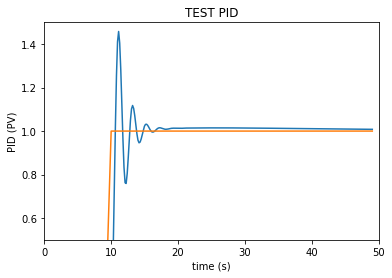

In [101]:
plt.plot(time_smooth, feedback_smooth)
plt.plot(time_list, setpoint_list)
plt.xlim((0, L))
plt.ylim((min(feedback_list)-0.5, max(feedback_list)+0.5))
plt.xlabel('time (s)')
plt.ylabel('PID (PV)')
plt.title('TEST PID')

plt.ylim((1-0.5, 1+0.5))

In [102]:
## PTerm, ITerm, DTerm을 state로 쓰기위해 time별로 묶기

states = np.array([p_term_list, i_term_list, d_term_list])
states_t = np.transpose(states)

In [103]:
states_t[8:15]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.42662859e+00,  2.02822685e-02,  4.93041495e+01],
       [-6.23531557e-01,  1.14837385e-02, -7.13861994e+01],
       [ 3.03208866e-01,  1.57555699e-02,  3.23194572e+01],
       [-1.31922096e-01,  1.38979898e-02, -1.51833684e+01],
       [ 5.91941336e-02,  1.47316342e-02,  6.66766171e+00]])

In [104]:
## reward 전처리
rewards = np.abs(np.array(error_list))*(-1)
rewards[6:15]

array([-0.        , -0.        , -0.        , -0.        , -1.        ,
       -0.43706649, -0.21253525, -0.09247123, -0.04149232])

In [105]:
## Policy output 조정
policy_outputs = np.array(feedback_list)

In [106]:
print(len(states_t))
print(len(policy_outputs))
print(len(rewards))

49
49
49


In [107]:
# REINFORCE

In [108]:
action = [kp, ki, kd]
states = states_t
policy_outputs = policy_outputs
rewards = rewards

for _ in range(episodes):
    for i in range(0,T-1):
        g = np.sum(rewards[i:])
        kp += lr_p * (states[i][0]/policy_outputs[i])*g if policy_outputs[i] != 0 else 0
        ki += lr_i * (states[i][1]/policy_outputs[i])*g if policy_outputs[i] != 0 else 0
        kd += lr_d * (states[i][2]/policy_outputs[i])*g if policy_outputs[i] != 0 else 0

    print(kp, ki, kd)

1.413907408415664 4.992375046939945 1.3758185740649613e-06
1.4011862268053414 4.990838596290832 1.5521142083892652e-06
1.388465045195019 4.989302145641719 1.728409842713569e-06
1.3757438635846964 4.987765694992605 1.904705477037873e-06
1.3630226819743738 4.986229244343492 2.081001111362177e-06


In [109]:
# kp = 1.5
# ki = 5
# kd = 0

1.3630226819743738 4.986229244343492 2.081001111362177e-06


(0.5, 1.5)

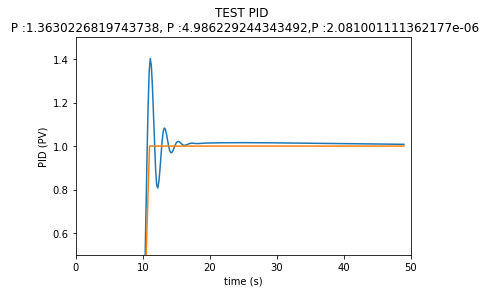

In [110]:
## 결과 확인하기
print(kp, ki, kd)
pid = PID.PID(kp, ki, kd)

pid.SetPoint=0.0
pid.setSampleTime(0.01)

END = L
feedback = 0

feedback_list = []
time_list = []
setpoint_list = []

for i in range(1, END):
    pid.update(feedback)    
    output = pid.output
    if pid.SetPoint > 0:
        feedback += (output - (1/i))
    if i>9:
        pid.SetPoint = 1
    time.sleep(0.02)

    feedback_list.append(feedback)
    setpoint_list.append(pid.SetPoint)
    time_list.append(i)

time_sm = np.array(time_list)
time_smooth = np.linspace(time_sm.min(), time_sm.max(), 300) 
feedback_smooth = make_interp_spline(time_list, feedback_list)(time_smooth)

plt.plot(time_smooth, feedback_smooth)
plt.plot(time_list[1:], setpoint_list[:-1])
plt.xlim((0, L))
plt.ylim((min(feedback_list)-0.5, max(feedback_list)+0.5))
plt.xlabel('time (s)')
plt.ylabel('PID (PV)')
plt.title(f'TEST PID \n P :{kp}, P :{ki},P :{kd}')

plt.ylim((1-0.5, 1+0.5))

오호.. 한번 더 해보기로 했다

In [111]:
# 재시도

L = 50
print(kp, ki, kd)
pid = PID.PID(kp, ki, kd)

pid.SetPoint=0.0
pid.setSampleTime(0.01)

END = L
feedback = 0

feedback_list = []
time_list = []
setpoint_list = []

p_term_list = []
i_term_list = []
d_term_list = []
error_list = []

for i in range(1, END):
    pid.update(feedback)
    
    p_term_list.append(pid.PTerm)
    i_term_list.append(pid.ITerm)
    d_term_list.append(pid.DTerm)
    error_list.append(pid.last_error)
    
    output = pid.output
    if pid.SetPoint > 0:
        feedback += (output - (1/i))
    if i>9:
        pid.SetPoint = 1
    time.sleep(0.02)

    feedback_list.append(feedback)
    setpoint_list.append(pid.SetPoint)
    time_list.append(i)

time_sm = np.array(time_list)
time_smooth = np.linspace(time_sm.min(), time_sm.max(), 300) 
feedback_smooth = make_interp_spline(time_list, feedback_list)(time_smooth)

1.3630226819743738 4.986229244343492 2.081001111362177e-06


(0.5, 1.5)

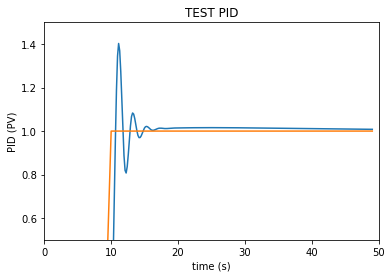

In [112]:
plt.plot(time_smooth, feedback_smooth)
plt.plot(time_list, setpoint_list)
plt.xlim((0, L))
plt.ylim((min(feedback_list)-0.5, max(feedback_list)+0.5))
plt.xlabel('time (s)')
plt.ylabel('PID (PV)')
plt.title('TEST PID')

plt.ylim((1-0.5, 1+0.5))

In [113]:
## PTerm, ITerm, DTerm을 state로 쓰기위해 time별로 묶기

states = np.array([p_term_list, i_term_list, d_term_list])
states_t = np.transpose(states)

In [114]:
states_t[8:15]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.36302268e+00,  2.01845169e-02,  4.95429246e+01],
       [-5.08218434e-01,  1.26618694e-02, -6.80461076e+01],
       [ 2.12218637e-01,  1.57952593e-02,  2.62638853e+01],
       [-7.96167852e-02,  1.46190558e-02, -1.06329564e+01],
       [ 2.69354958e-02,  1.50174770e-02,  3.87738737e+00]])

In [115]:
## reward 전처리
rewards = np.abs(np.array(error_list))*(-1)
rewards[6:15]

array([-0.        , -0.        , -0.        , -0.        , -1.        ,
       -0.37286132, -0.15569707, -0.05841193, -0.01976159])

In [116]:
## Policy output 조정
policy_outputs = np.array(feedback_list)

In [117]:
print(len(states_t))
print(len(policy_outputs))
print(len(rewards))

49
49
49


In [118]:
# REINFORCE

In [119]:
action = [kp, ki, kd]
states = states_t
policy_outputs = policy_outputs
rewards = rewards

for _ in range(episodes):
    for i in range(0,T-1):
        g = np.sum(rewards[i:])
        kp += lr_p * (states[i][0]/policy_outputs[i])*g if policy_outputs[i] != 0 else 0
        ki += lr_i * (states[i][1]/policy_outputs[i])*g if policy_outputs[i] != 0 else 0
        kd += lr_d * (states[i][2]/policy_outputs[i])*g if policy_outputs[i] != 0 else 0

    print(kp, ki, kd)

1.3492862363217961 4.9846965258381495 2.0620653814771466e-06
1.3355497906692184 4.983163807332807 2.0431296515921163e-06
1.3218133450166407 4.981631088827465 2.024193921707086e-06
1.308076899364063 4.980098370322122 2.005258191822056e-06
1.2943404537114853 4.97856565181678 1.9863224619370255e-06


In [120]:
# kp = 1.5
# ki = 5
# kd = 0

1.2943404537114853 4.97856565181678 1.9863224619370255e-06


(0.5, 1.5)

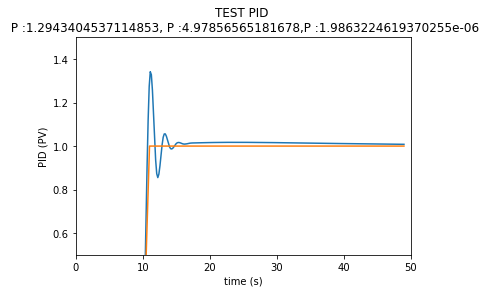

In [121]:
## 결과 확인하기
print(kp, ki, kd)
pid = PID.PID(kp, ki, kd)

pid.SetPoint=0.0
pid.setSampleTime(0.01)

END = L
feedback = 0

feedback_list = []
time_list = []
setpoint_list = []

for i in range(1, END):
    pid.update(feedback)    
    output = pid.output
    if pid.SetPoint > 0:
        feedback += (output - (1/i))
    if i>9:
        pid.SetPoint = 1
    time.sleep(0.02)

    feedback_list.append(feedback)
    setpoint_list.append(pid.SetPoint)
    time_list.append(i)

time_sm = np.array(time_list)
time_smooth = np.linspace(time_sm.min(), time_sm.max(), 300) 
feedback_smooth = make_interp_spline(time_list, feedback_list)(time_smooth)

plt.plot(time_smooth, feedback_smooth)
plt.plot(time_list[1:], setpoint_list[:-1])
plt.xlim((0, L))
plt.ylim((min(feedback_list)-0.5, max(feedback_list)+0.5))
plt.xlabel('time (s)')
plt.ylabel('PID (PV)')
plt.title(f'TEST PID \n P :{kp}, P :{ki},P :{kd}')

plt.ylim((1-0.5, 1+0.5))